In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from numba import jit

In [3]:
output_path = '/home/bruce1996/data/pr/0707/'

In [2]:
deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
humann_output = '/home/bruce1996/ssd/mci_rel_pathabundance.tsv'
metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
humann_df = pd.read_csv(humann_output,sep = '\t',index_col=0)
humann_df.index.name = None
deseq_df = pd.read_csv(deseq_output,sep = '\t',index_col = 0)
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)

In [3]:
corr_m = meta_df.T.corr('spearman')
tmp = corr_m.copy()
ut = np.triu(tmp,k=1)
ut = np.where(ut==0, np.nan, ut)
ut_df = pd.DataFrame(ut,index = corr_m.index,columns = corr_m.columns)
tmp = ut_df
tmp['taxa'] = ut_df.index
tmp = tmp.melt(id_vars='taxa')
tmp.columns = ['t1','t2','corr']

In [4]:
##remove un of humann result
idx = [bool(re.search('UN',x)) == False for x in humann_df.index]
humann_df = humann_df.loc[idx,:]
##remove special charcter from humann output index
removeSpecialChars = lambda x : x.translate ({ord(c): "" for c in "[]"})
humann_df.index = list(map(removeSpecialChars,list(humann_df.index) ))

In [5]:
select_feature_list  = "/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt"

select_feature = pd.read_csv(select_feature_list,sep='\t',header=None)
select_feature.columns = ['Species']
candidate_df = deseq_df.loc[select_feature['Species'].values,:]


In [7]:
import seaborn as sns
from math import log10

def valcano_plot_for_deseq2(deseq_df,figname,title,fc_threshold = 1,pv_threshold = 0.05,figsize= (10,6)) :
    '''
    function of deseq2 result output to valcano plot
    deseq_df : dataframe, deseq result output
    fc_threshold : int/float, significant threshold of log2foldchange 
    pv_threshold : float, significant threhold of p-value
    '''
    plot_df = deseq_df.copy()
    plot_df['Significant'] = np.where((abs(plot_df['log2FoldChange']) > fc_threshold) & (plot_df['pvalue'] < pv_threshold), 'Significant','Non-significant')
    plt.figure(figsize=figsize)
    plot_df['log10 pvalue'] = [abs(log10(x)) for x in plot_df['pvalue'].values]
    sns.scatterplot(data = plot_df,x = 'log2FoldChange',y = 'log10 pvalue',hue='Significant',palette='Set2')
    max_fc = max(abs(plot_df['log2FoldChange']))
    plt.xlim([-1 * max_fc,max_fc])
    plt.title(title,fontsize = 12)
    plt.savefig(figname,dpi = 300)


In [6]:
@jit(nopython=True)
def enrich_score(taxa_array) : 
    '''
    pathway : name of pathway, ex : DTDPRHAMSYN-PWY: dTDP-&beta;-L-rhamnose biosynthesis
    taxonomy_list : taxonomy list with "order"
    '''
    #calculate enrichment score unit, enrichment score upper bond = 1, lower bond = -1
    es = 0
    max_es = 0
    es_pos = 1/sum(taxa_array)
    es_n = 1/(len(taxa_array) - sum(taxa_array))
    #calculate enrichment score by "ordered" taxonomy list
    for t in taxa_array :
        if t  == 1 :
            es += es_pos
        elif t == 0 :
            es -= es_n
        else :
            print('Value in taxa array must be 0 or 1')
            break
        if es > max_es :
            max_es = es
    return max_es

@jit(nopython=True)
def permutation(taxa_array,n_times = 1000) :
    
    origin_es = enrich_score(taxa_array)
    permutation_es = np.zeros(n_times)
    for i in range(n_times) :
        np.random.shuffle(taxa_array)
        permutation_es[i] = enrich_score(taxa_array)
    es_above_origin = sum(permutation_es > origin_es)
    if es_above_origin == 0 :
        pesudo_f = 1/ (n_times * 10)
    else :
        pesudo_f = es_above_origin / n_times
    return pesudo_f,origin_es

In [14]:
import random
import time
from scipy.stats import spearmanr

class taxonomy_enrich_analysis :

    def __init__(self,deseq_output,metaphlan_output,humann_index) :
        self.deseq = deseq_output
        self.metaphlan_output = metaphlan_output
        self.taxonomy = list(self.deseq.index)
        self.humann_index = humann_index
        p_idx = [bool(re.search("^(?!.*\|)",x)) for x in self.humann_index]
        self.pathway_list = self.humann_index[p_idx]
        self.pseudo_p_value = np.zeros(len(self.pathway_list))
        self.es_score = np.zeros(len(self.pathway_list))

    def sort_taxonomy(self,method='fold-change') :
        if method == 'fold-change' :
            self.deseq = self.deseq.sort_values(by='log2FoldChange',ascending=False)
            self.taxonomy = list(self.deseq.index)
        elif method == 'p-value' :
            self.deseq = self.deseq.sort_values(by='padj',ascending=False)
            self.taxonomy = list(self.deseq.index)
        else :
            self.taxonomy = self.taxonomy

    def sort_taxonomy_edge(self,method = 'spearman') :
        '''
        corr_matrix = self.metaphlan_output.T.corr(method)
        ut = np.triu(corr_matrix.to_numpy(),k=1)
        ut = np.where(ut==0, np.nan, ut)
        ut_df = pd.DataFrame(ut,index = corr_matrix.index,columns = corr_matrix.columns)
        ut_df['taxa'] = corr_matrix.index
        ut_df = ut_df.melt(id_vars='taxa')
        ut_df.columns = ['T1','T2','corr']
        idx = ut_df['corr'].isnull() == False
        ut_df = ut_df.loc[idx,:].sort_values(by='corr')
        '''
        corr_z_dict = dict()
        corr_df = self.metaphlan_output
        n = corr_df.shape[0]
        for col in range(n-1) :
            for row in range(col+1,n) :
                name = (corr_df.index[col],corr_df.index[row])
                t1 = corr_df.iloc[col,:]
                t2 = corr_df.iloc[row,:]
                idx = (t1 + t2) > 0
                r,p = spearmanr(t1[idx],t2[idx])
                z = np.arctanh(r)
                corr_z_dict[name] = z
        df = pd.DataFrame({'Name' : corr_z_dict.keys(),'z-score' : corr_z_dict.values()}).sort_values(by='z-score',ascending=False)
        self.taxonomy = list(df['Name'].values)
        del df
    
    def format_taxa_array(self,pathway,taxa_list,mode='Node') :
        taxa_idx = [bool(re.search(pathway,x)) for x in self.humann_index]
        taxa_in_path = self.humann_index[taxa_idx]

        taxa_in_pathway = lambda x : x.split('|')[-1].split('.')[-1]
        taxa_in_path = list(map(taxa_in_pathway,taxa_in_path[1:]))
        taxa_array = np.zeros(len(taxa_list))
        for idx,t in enumerate(taxa_list) :
            if mode == 'Node' :
                if t in taxa_in_path :
                    taxa_array[idx] = 1
            else :
                if t[0] in taxa_in_path and t[1] in taxa_in_path :
                    taxa_array[idx] = 1

        return taxa_array

    def TSEA(self,mode='Node') :
        if mode == 'Node' :
            self.sort_taxonomy()
        elif mode == 'Edge' :
            self.sort_taxonomy_edge()
        else :
            print('Only have Node/Edge mode for taxonomy set enrichment analysis')
            return
        print('taxonomy list length : %d' % len(self.taxonomy))
        for idx,p in enumerate(self.pathway_list) :
            start_time = time.time()
            print('Calculate enrichment score of {idx} / {total}  pathway : {pathway}'.format(idx =idx+1,total = len(self.pathway_list),pathway =p))
     
            if mode == 'Node' :
                taxa_array = self.format_taxa_array(p,self.taxonomy)
            else :
                taxa_array = self.format_taxa_array(p,self.taxonomy,mode='Edge')
            if sum(taxa_array) == 0 :
                pass
            else :
                self.pseudo_p_value[idx],self.es_score[idx] = permutation(taxa_array)
            
            end_time = time.time()
            time_delta = round(end_time - start_time,2)
            #print('Pathway : {p} pesudo-F : {f}, enrich score : {es}'.format(p=p,f=self.pseudo_p_value[idx],es=self.es_score[idx] ))
            print('TSEA of pathway : %s cost %0.2f s' % (p,time_delta))

        tsea_result = pd.DataFrame({'Pathway' : self.pathway_list,'Enrich_score' : self.es_score,'p-value' : self.pseudo_p_value})
        return tsea_result


In [15]:
tt = taxonomy_enrich_analysis(deseq_df,meta_df,humann_df.index)
#node_tsea = tt.TSEA()

### plot

In [10]:
import matplotlib

humann_tsea = pd.read_csv('/home/bruce1996/data/MCI/tsea/Humann-tsea-result.txt',sep='\t',index_col=0)
humann_df = pd.read_csv('/home/bruce1996/data/MCI/merge_mci_humann_result_relab.txt',sep='\t',index_col=0)
keep_idx = humann_tsea['Node-pseudo-F'].values  + humann_tsea['Edge-pseudo-F'].values > 0
humann_tsea = humann_tsea.loc[keep_idx,:]
metadata = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_sample_diagnosis.csv',sep = '\t',index_col=0)
##plot
cmap = plt.cm.gist_rainbow
colors = cmap(np.linspace(0., 1., 20))
matplotlib.colors.rgb2hex(colors[2])
##filter humann output
idx = (humann_tsea['Node-pseudo-F'] < 0.05) & (humann_tsea['Edge-pseudo-F'] < 0.05)
sig_path = humann_tsea.loc[idx,:]

In [16]:
max(humann_df.median(axis=1))

0.7654985000000001

In [33]:
idx = [bool(re.search('\|',x))  == False for x in humann_df.index]
humann_r = humann_df.loc[idx,:]
humann_r = humann_r.iloc[2:,:]

In [37]:
import networkx as nx
from scipy.stats import spearmanr
def create_corr_network(df) :
    n = df.shape[0]
    corr_z_dict = dict()
    for col in range(n-1) :
        for row in range(col+1,n) :
            name = (df.index[col],df.index[row])
            t1 = df.iloc[col,:]
            t2 = df.iloc[row,:]
            idx = (t1 + t2) > 0
            r,p = spearmanr(t1[idx],t2[idx])
            z = np.arctanh(r)
            corr_z_dict[name] = z

    g = nx.Graph()
    g.add_nodes_from(corr_z_dict.keys())
    #only add edge
    g.add_edges_from(corr_z_dict)
    #add z score of edge to graph object
    nx.set_edge_attributes(g,corr_z_dict,'weight')
    #add node attribute
    pv_lambda = lambda x : 100 * (sum(x > 0) / len(x))
    pv = list(map(pv_lambda,df.to_numpy()))
    pv_dict = dict(zip(df.index,pv))

    m_ab = df.mean(axis=1)
    mab_dict = dict(zip(df.index,m_ab))
    nx.set_node_attributes(g,pv_dict,name='Prevalence')
    nx.set_node_attributes(g,mab_dict,name='Mean abundance')

    return g

def filter_corr_network(g,threshold,pos_only=False,p_color = '#66c2a5',n_color='#fc8d62'):
    g_c = g.copy()
    color_dict = dict()
    #p_color = ImageColor.getcolor(p_color, "RGB")
    #n_color = ImageColor.getcolor(n_color, "RGB")
    for n1,n2,w in g_c.edges(data=True) :
        if pos_only :
            if w['weight'] < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
        else :
            if abs(w['weight']) < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
    nx.set_edge_attributes(g,color_dict,name='Color')
    #remove node degree = 1
    g_c = g.copy()
    for n,d in g_c.degree :
        if d < 2 :
            g.remove_node(n)

In [65]:
def plot_corr_network(G,title,fig_output,fontsize=None,figsize = (20,12)) :

    plt.figure(figsize = figsize)
    #pos = nx.spring_layout(G,k = 4 / sqrt(G.order()))
    pos = nx.random_layout(G)
    #pos = nx.multipartite_layout(G,subset_key='Cluster')
    #plot node
    node_color_list = nx.get_node_attributes(G,'Color').values()
    nx.draw_networkx_nodes(G,pos,node_color=node_color_list,alpha=0.8,node_size = [v[1] ** 3 for v in G.degree]) 
    species = list(pos.keys())
    for idx in range(len(pos)) :
        s = species[idx]
        x = pos[s][0]
        y = pos[s][1]
        if fontsize == None :
            plt.text(x,y,s,fontsize = G.degree[s],horizontalalignment='center',verticalalignment='center')  
        else :
            plt.text(x,y,s,fontsize = fontsize,horizontalalignment='center',verticalalignment='bottom')
    #plot edge
    edge_color = nx.get_edge_attributes(G,'Color').values()
    nx.draw_networkx_edges(G,pos,edge_color=edge_color)
    #plot legend
    node_cluser_list = nx.get_node_attributes(G,'Cluster').values()
    legend_dict = dict(zip(node_cluser_list,node_color_list))
    
    for cl,col in legend_dict.items() :
        plt.plot([],[],color = col,label = cl)
    
    plt.legend()
    plt.title(title,fontsize = 15)
    plt.savefig(fig_output)
    plt.show()

In [70]:
sig_path.to_csv(output_path + 'sig_path.txt',sep='\t')

No handles with labels found to put in legend.


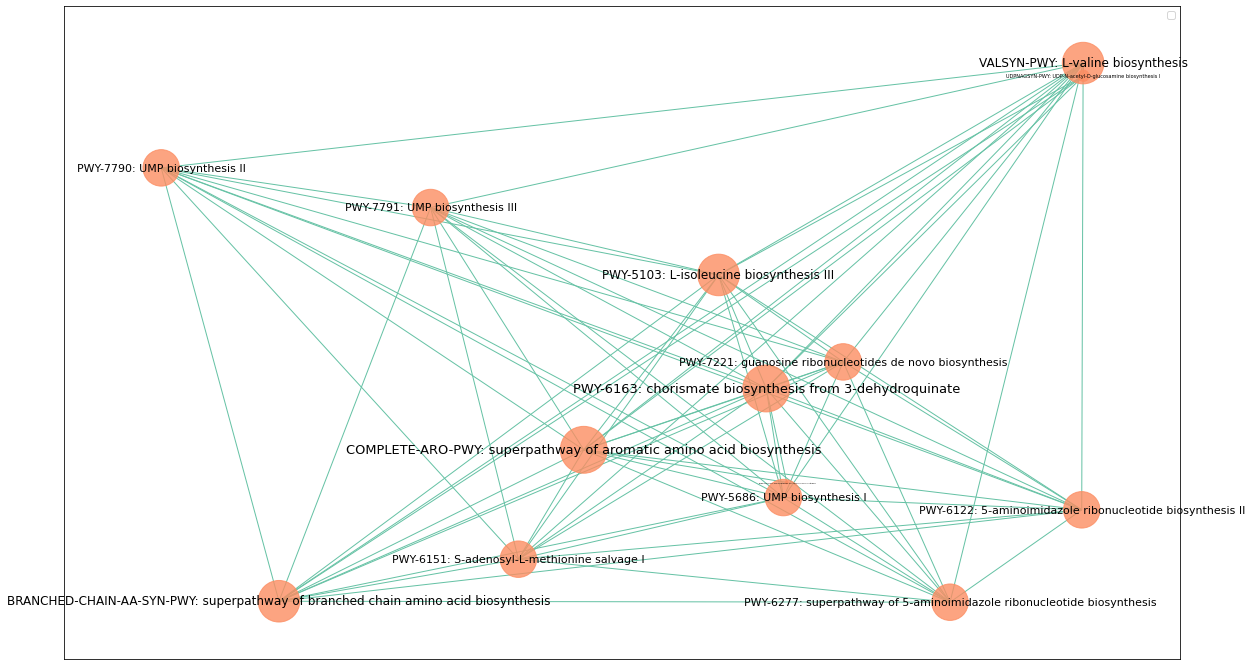

In [68]:
humann_rr = humann_r.loc[sig_path['Name'],:]
g = create_corr_network(humann_rr)
filter_corr_network(g,0.3)

nodes = list(g.nodes())
nodes_color_dict = dict()
for n in nodes :
    nodes_color_dict[n] = '#fc8d62'

nx.set_node_attributes(g,nodes_color_dict,name = 'Color')

plot_corr_network(g,'',output_path + 'humann-tsea-co-expression-network.png')

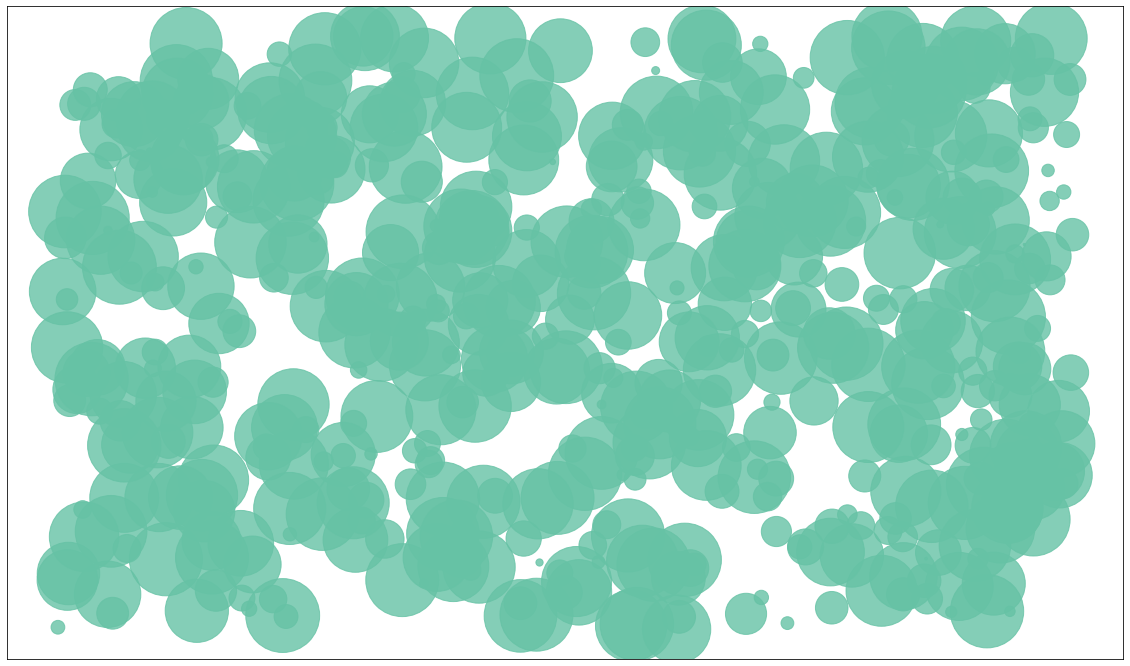

In [57]:
plt.figure(figsize = (20,12))
#pos = nx.spring_layout(G,k = 4 / sqrt(G.order()))
pos = nx.random_layout(g)
#pos = nx.multipartite_layout(G,subset_key='Cluster')
#plot node
node_color_list = nx.get_node_attributes(g,'Color').values()
nx.draw_networkx_nodes(g,pos,node_color=node_color_list,alpha=0.8,node_size = [v[1] ** 1.5 for v in g.degree]) 


In [34]:
humann_r

,TPMIC01002-LEB7250_Abundance,TPMIC01004-LEB7253_Abundance,TPMIC01005-LEB7251_Abundance,TPMIC01006-LEB7254_Abundance,TPMIC01007-LEB7252_Abundance,TPMIC01008-LEB7255_Abundance,TPMIC01009-LEB7257_Abundance,TPMIC01010-LEB7256_Abundance,TPMIC01011-LEB7258_Abundance,TPMIC01015-LEB7267_Abundance,...,TPMIC03051-LEB7337_Abundance,TPMIC03066-LEB7338_Abundance,TPMIC03070-LEB7346_Abundance,TPMIC03071-LEB7285_Abundance,TPMIC03072-LEB7286_Abundance,TPMIC03075-LEB7287_Abundance,TPMIC03083-LEB7339_Abundance,TPMIC03084-LEB7288_Abundance,TPMIC03089-LEB7340_Abundance,TPMIC03091-LEB7341_Abundance
# Pathway,,,,,,,,,,,,,,,,,,,,,
"12DICHLORETHDEG-PWY: 1,2-dichloroethane degradation",0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,1.973970e-06,0.000000e+00,0.000000e+00,0.000000e+00,1.882200e-07,0.000000e+00,0.000000e+00
1CMET2-PWY: folate transformations III (E. coli),4.333170e-04,4.037220e-04,4.026990e-04,0.000377,0.000630,0.000559,3.193590e-04,0.000348,4.705860e-04,3.711860e-04,...,4.357700e-04,0.000449,0.000418,3.268720e-04,4.338790e-04,3.969290e-04,4.122640e-04,3.954360e-04,4.342720e-04,3.046820e-04
3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation,9.293400e-05,1.002690e-05,1.022080e-05,0.000000,0.000001,0.000000,9.891040e-05,0.000026,2.466940e-06,4.133220e-07,...,7.279510e-07,0.000003,0.000000,9.251290e-06,0.000000e+00,0.000000e+00,7.725250e-07,5.732690e-06,1.258370e-07,5.516670e-07
AEROBACTINSYN-PWY: aerobactin biosynthesis,0.000000e+00,7.129120e-07,4.202460e-07,0.000000,0.000000,0.000000,2.920680e-07,0.000000,3.104410e-06,2.137110e-06,...,0.000000e+00,0.000000,0.000000,1.553480e-05,0.000000e+00,0.000000e+00,0.000000e+00,3.931780e-06,0.000000e+00,6.217420e-07
ALL-CHORISMATE-PWY: superpathway of chorismate metabolism,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UDPNACETYLGALSYN-PWY: UDP-N-acetyl-D-glucosamine biosynthesis II,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,6.951420e-06,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.288950e-06
UDPNAGSYN-PWY: UDP-N-acetyl-D-glucosamine biosynthesis I,3.483040e-04,1.337380e-04,2.082550e-04,0.000170,0.000141,0.000214,2.655860e-04,0.000201,2.288870e-04,2.260760e-04,...,2.934550e-04,0.000148,0.000309,9.817420e-05,1.092690e-04,4.294530e-04,3.205330e-04,2.754880e-04,1.376310e-04,1.284020e-04
URDEGR-PWY: superpathway of allantoin degradation in plants,1.866010e-07,1.218660e-06,3.020070e-06,0.000000,0.000001,0.000000,2.941000e-06,0.000001,6.233060e-07,1.509010e-06,...,1.494040e-06,0.000000,0.000000,3.151220e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.028450e-05,2.399400e-07,2.095130e-07


In [ ]:
#plot with text
n = sig_path.shape[0]
cmap = plt.cm.gist_rainbow
colors = cmap(np.linspace(0., 1., n))
plt.figure(figsize=(10,8))
plt.xlim([0,0.05])
plt.ylim([0,0.05])
for i in range(n) :
    s,n,e = sig_path.iloc[i,:]
    c = matplotlib.colors.rgb2hex(colors[i])
    plt.scatter(e,n,color= c)
    plt.text(e,n,s,fontsize = 10,color = c,rotation=0,horizontalalignment='left',verticalalignment='bottom')  
plt.ylabel('Node pseudo-F p-value')
plt.xlabel('Edge pseudo-F p-value')
plt.title('Taxonomy set enrichment analysis of humann output')
plt.savefig(output_path + 'Humann-tsea-scatterplot-cross-threshold.png',dpi = 300)  
#plot
plt.figure(figsize=(10,8))
sns.scatterplot(data= humann_tsea,x = 'Edge-pseudo-F',y = 'Node-pseudo-F',palette="rainbow")
plt.title('Taxonomy set enrichment analysis')
plt.ylabel('Node pseudo-F p-value')
plt.xlabel('Edge pseudo-F p-value')
plt.savefig(output_path + 'Humann-tsea-scatterplot.png',dpi = 300)